In [1]:
''' 
written by: Jonathan Pilgram, november '23 - august '24
'''

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rom
import pandas as pd
import patchworklib as pw
import control as ct
import h5py
import scipy

# 9 colors colorblind friendly palette
cbbPalette = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
def repeating_palette(n):
    return (cbbPalette * (n // len(cbbPalette) + 1))[:n]

# Roboto font for matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Roboto",
    "text.latex.preamble": r"""
        \usepackage{roboto}
        \renewcommand{\familydefault}{\sfdefault}
        \usepackage{sfmath}
    """
})
from plotnine import *

%load_ext autoreload
%autoreload 2
%aimport rom

No module named 'seaborn'


<Figure size 100x100 with 0 Axes>

In [2]:
# Neutron flux MSFR
flux = np.loadtxt("./serpent/geometry/input_det0.m")[:, -2]
flux = flux / np.max(flux)
X = np.linspace(-100, 100, 100)
df = pd.DataFrame({"x": X, "Neutron flux": flux})
plot = (
    ggplot(df, aes(x="x", y="Neutron flux"))
    + geom_line(size=0.65)
    + ylab(r"$\phi/\phi_\mathrm{max}$")
    + xlab("x-coordinate")
    + theme(
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
    )
    + theme_linedraw()
)
ggsave(plot, "../writing/figures/MSFR_neutronFlux.png", width=3, height=3, dpi=300)

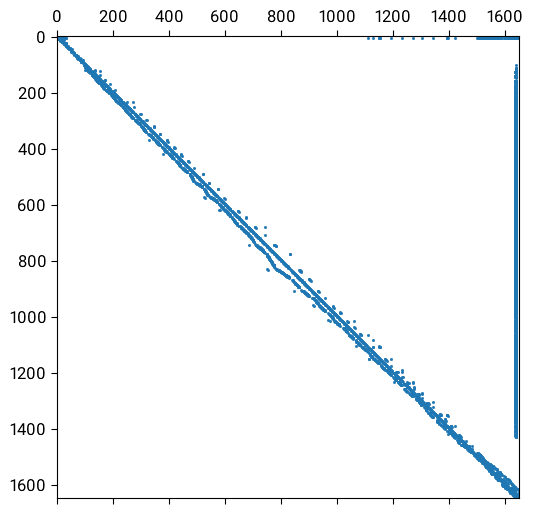

In [6]:
# Sparsity pattern decay array
decay = rom.read_burnup_file("serpent/matrix_0W_1day.m")
decay = decay["A"]

# Plot the sparsity pattern
plt.figure(figsize=(6, 6))
plt.spy(decay, markersize=1)
plt.savefig("../writing/figures/burnupmatrix_decay.png", dpi=300)
plt.show()

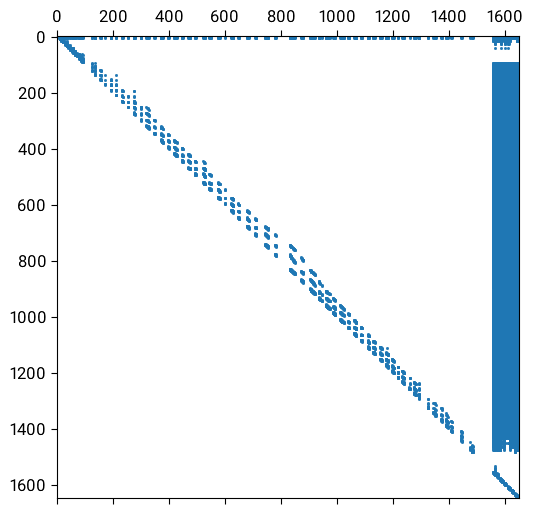

In [7]:
# Sparsity pattern nuclear reactions
decay = rom.read_burnup_file("serpent/matrix_0W_1day.m")
decay = decay["A"]
reactions = rom.read_burnup_file("serpent/matrix_100W_1day.m")
reactions = reactions["A"]

# Plot the sparsity pattern
plt.figure(figsize=(6, 6))
plt.spy(reactions - decay, markersize=1)
plt.savefig("../writing/figures/burnupmatrix_reactions.png", dpi=300)
plt.show()

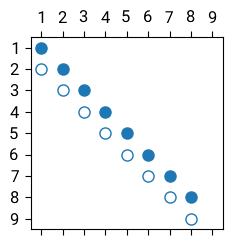

In [7]:
# Sparsity pattern decay chain
sparse = rom.DecayChain(9)
rom.build_decay_chain(sparse, 1, 1)
pos = sparse.decay_array > 0
neg = sparse.decay_array < 0

# Plot the sparsity pattern
plt.figure(figsize=(2.5, 2.5))
plt.spy((sparse.decay_array * pos), markersize=8, marker="o", markerfacecolor="none")
plt.spy(
    (sparse.decay_array * neg),
    markersize=8,
    marker="o",
)

ax = plt.gca()
ax.set_xticks(np.arange(sparse.decay_array.shape[1]))
ax.set_yticks(np.arange(sparse.decay_array.shape[0]))
ax.set_xticklabels(np.arange(1, sparse.decay_array.shape[1] + 1))
ax.set_yticklabels(np.arange(1, sparse.decay_array.shape[0] + 1))
plt.savefig("../writing/figures/burnupmatrix_decayChain.png", dpi=300)
plt.show()

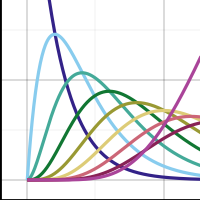

In [14]:
# Plot to show decay chain model
def ggplotroutine(solution, title: str, N_nuclides: int, shwlegend=False):
    nuclides = []
    for a in range(N_nuclides):
        nuclides.append("$N_" + str(a + 1) + "$")

    df = pd.DataFrame(
        np.vstack((solution.t, solution.y)).T,
        columns=["Time (s)"] + nuclides,
    )
    df = pd.melt(
        df,
        value_vars=nuclides,
        id_vars="Time (s)",
        var_name="Nuclide",
        value_name="Nuclide amount",
    )
    plot = (
        ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
        + ylab("")
        + geom_line(aes(color="Nuclide"), size=0.65, show_legend=shwlegend)
        + theme_linedraw()
        + ggtitle(title)
        + scale_color_manual(cbbPalette)
        + theme(legend_key=element_blank(), legend_background=element_blank())
    )
    return plot


ex = rom.DecayChain(9, False)
ex.initial_composition[0] = 1
rom.build_decay_chain(ex, 20, 20)
ex.run_simulation(1, 1000, "Euler_backward")
constant_decay = pw.load_ggplot(
    ggplotroutine(ex.solution, "Unvarying decay constants", 9, False), (3, 2.2)
)
ex = rom.DecayChain(9, False)
ex.initial_composition[0] = 1
rom.build_decay_chain(ex, 5, 75)
ex.run_simulation(1, 1000, "Euler_backward")
random_decay = pw.load_ggplot(
    ggplotroutine(ex.solution, "Varying decay constants", 9, True), (3, 2.2)
)
plots = pw.stack([constant_decay, random_decay], margin=0.1, operator="+")
plots.set_supylabel("Nuclide amount")
plots.savefig("../writing/figures/decay_chain_example")

In [6]:
# Example plot of singular value decay
test = rom.DecayChain(8, False)
test.initial_composition[0] = 1
rom.build_decay_chain(test, 5, 75, 25)
test.run_simulation(1, 1000)
rom.spatial_snapshots(test, 1000)
rom.reduce_SVD(test)
data = pd.DataFrame(
    np.vstack((np.arange(8) + 1, test.singular_values)).T,
    columns=["Singular value", "Magnitude"],
)
plot = (
    ggplot(pd.DataFrame(data), aes(x="Singular value", y="Magnitude"))
    + geom_point()
    + scale_y_log10()
    + scale_x_continuous(breaks=range(1, 9))
    + theme_linedraw()
)
ggsave(plot, "../writing/figures/singular_value_decay", width=4, height=2.6666, dpi=300)

Normalised total error: 9.993e-01
2
Normalised total error: 8.589e-01
3
Normalised total error: 5.109e-01
4
Normalised total error: 1.212e-01
5
Normalised total error: 4.636e-02
6
Normalised total error: 7.334e-03
7
Normalised total error: 2.132e-04
8
Normalised total error: 1.160e-05


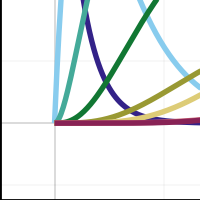

In [15]:
# Plot to show buildup of orders
def ggplotroutine(
    solution,
    title: str,
    N_nuclides: int,
    shwylabel=False,
    shwlegend=False,
    shw1tick=False,
):
    nuclides = []
    for a in range(N_nuclides):
        nuclides.append("$N_" + str(a + 1) + "$")

    df = pd.DataFrame(
        np.vstack((solution.t, solution.y)).T,
        columns=["Time (s)"] + nuclides,
    )
    df = pd.melt(
        df,
        value_vars=nuclides,
        id_vars="Time (s)",
        var_name="Nuclide",
        value_name="Nuclide amount",
    )
    max_time = df["Time (s)"].max()
    time_breaks = np.linspace(df["Time (s)"].min(), max_time, num=6)  # [:-1]
    time_breaks[0] = 0
    time_breaks[-1] = 1
    plot = (
        ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
        + ylab("")
        + geom_line(aes(color="Nuclide"), size=1.1, show_legend=shwlegend)
        + theme(legend_key=element_blank(), legend_background=element_blank())
        + theme_linedraw()
        + ggtitle(title)
        + scale_color_manual(cbbPalette)
        + ylim(-0.1, 1)
        + scale_x_continuous(breaks=time_breaks[:-1])
    )
    if shwylabel == False:
        plot += theme(
            axis_title_y=element_blank(),
            axis_text_y=element_blank(),
            axis_ticks_major_y=element_blank(),
        )
    if shw1tick == True:
        plot += scale_x_continuous(breaks=time_breaks)
    return plot


test = rom.DecayChain(8, False)
test.initial_composition[0] = 1
rom.build_decay_chain(test, 5, 75, 25)
test.run_simulation(1, 1000)
rom.spatial_snapshots(test, 1000)
plt = {}
plt["full"] = ggplotroutine(
    test.solution, "Full order", 8, shwylabel=True, shwlegend=True, shw1tick=True
)
rom.reduce_SVD(test, 1)
test.run_simulation_reduced(test)
plt["1"] = ggplotroutine(
    test.solution_red, str(1) + " reduced order", 8, shwylabel=True
)
rom.print_error(test)

for i in range(1, 8):
    rom.reduce_SVD(test, i + 1)
    print(i + 1)
    test.run_simulation_reduced(test)
    if i == 3:
        plt["{0}".format(i + 1)] = ggplotroutine(
            test.solution_red,
            str(i + 1) + " reduced orders",
            8,
            shwylabel=True,
        )
    if i == 20:
        plt["{0}".format(i + 1)] = ggplotroutine(
            test.solution_red,
            str(i + 1) + " reduced orders",
            8,
            shwlegend=True,
        )
    if i == 2 or i == 5:
        plt["{0}".format(i + 1)] = ggplotroutine(
            test.solution_red,
            str(i + 1) + " reduced orders",
            8,
            shw1tick=True,
        )
    else:
        plt["{0}".format(i + 1)] = ggplotroutine(
            test.solution_red,
            str(i + 1) + " reduced orders",
            8,
        )
    rom.print_error(test)
rom.reduce_SVD(test, i + 1)
test.run_simulation_reduced(test)
f = pw.load_ggplot(plt["full"], figsize=(6, 3))
r1 = pw.load_ggplot(plt["1"], figsize=(2, 4 / 3))
r2 = pw.load_ggplot(plt["2"], figsize=(2, 4 / 3))
r3 = pw.load_ggplot(plt["3"], figsize=(2, 4 / 3))
r4 = pw.load_ggplot(plt["4"], figsize=(2, 4 / 3))
r5 = pw.load_ggplot(plt["5"], figsize=(2, 4 / 3))
r6 = pw.load_ggplot(plt["6"], figsize=(2, 4 / 3))
r7 = pw.load_ggplot(plt["7"], figsize=(2, 4 / 3))
r8 = pw.load_ggplot(plt["8"], figsize=(2, 4 / 3))
top = f
middle = pw.stack([r1, r2, r3], margin=0, operator="+")
bottom = pw.stack([r4, r5, r6], margin=0, operator="+")
total = pw.stack([top, middle, bottom], margin=0.1, operator="/")
# print(test.decay_array)
total.savefig("../writing/figures/order_buildup")

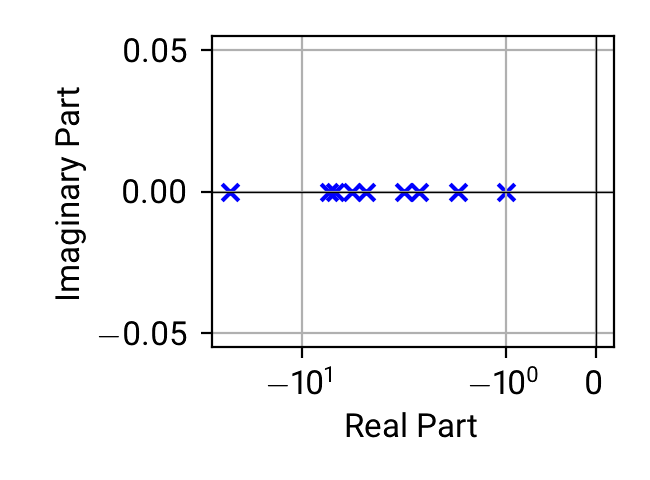

In [2]:
# Eigenvalues decay chain FOM
N_nuclides = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e2, 1)
POD.initial_composition[0] = 1
POD.run_simulation(
    np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
# rom.spatial_snapshots(POD, 5)
# rom.reduce_SVD(POD, 3)
# rom.run_simulation_reduced(POD)
eigs, eigvecs = np.linalg.eig(POD.decay_array)

# Make dataframes of results
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"

df = pd.DataFrame(
    np.vstack((POD.solution.t, POD.solution.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)


# Generate plots
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=1.1, show_legend=True)
    + theme_linedraw()
    + scale_color_manual(cbbPalette)
    + theme(figure_size=(3.25, 2.4), legend_key_size=12)
    + theme(legend_key=element_blank(), legend_background=element_blank())
)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig(
    "../writing/figures/POD-normal_eigen.png",
    bbox_inches="tight",
    pad_inches=0.03,
    dpi=300,
)

# Display the plot
ggsave(plot_chain, "../writing/figures/POD-normal_chain", dpi=300)

9.863591149078392


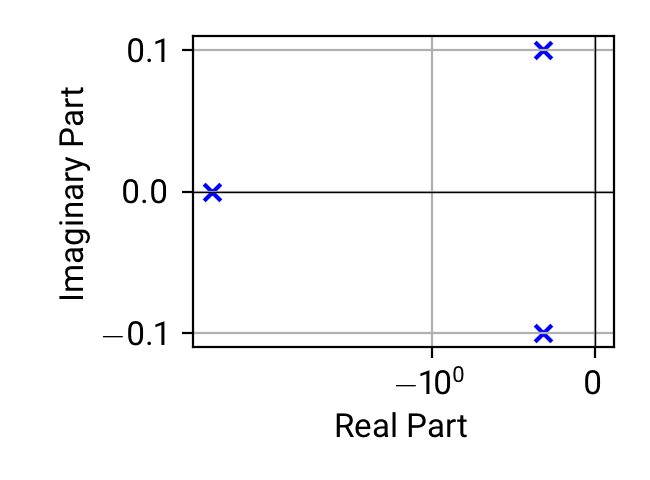

In [3]:
# Eigenvalues POD succes
N_nuclides = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e2, 422)
POD.initial_composition[0] = 1
POD.run_simulation(
    np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
rom.spatial_snapshots(POD, 5)
rom.reduce_SVD(POD, 3)
rom.run_simulation_reduced(POD)
eigs, eigvecs = np.linalg.eig(POD.decay_array_red)

# Make dataframes of results
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"

df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)


# Generate plots
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=1.1, show_legend=True)
    + theme_linedraw()
    + scale_color_manual(cbbPalette)
    + theme(figure_size=(3.25, 2.4), legend_key_size=12)
    + theme(legend_key=element_blank(), legend_background=element_blank())
)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig(
    "../writing/figures/POD-succes_eigen.png",
    bbox_inches="tight",
    pad_inches=0.03,
    dpi=300,
)

print(np.min(np.real(eigs)) / np.max(np.real(eigs)))
# Display the plot
ggsave(plot_chain, "../writing/figures/POD-succes_chain", dpi=300)

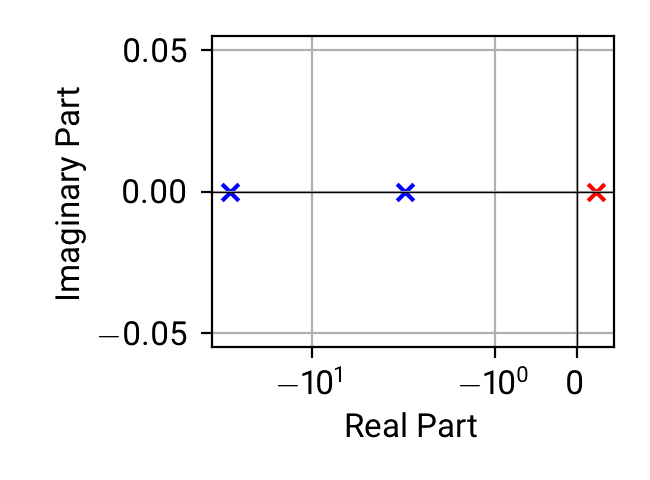

In [4]:
# Eigenvalues decay chain POD explode
N_nuclides = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e2, 13)
POD.initial_composition[0] = 1
POD.run_simulation(
    np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
rom.spatial_snapshots(POD, 5)
rom.reduce_SVD(POD, 3)
POD.sim_time = 20
rom.run_simulation_reduced(POD)
eigs, eigvecs = np.linalg.eig(POD.decay_array_red)

# Make dataframes of results
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"

df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)


# Generate plots
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=1.1, show_legend=True)
    + theme_linedraw()
    + scale_color_manual(cbbPalette)
    + theme(figure_size=(3.25, 2.4), legend_key_size=12)
    + theme(legend_key=element_blank(), legend_background=element_blank())
)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig(
    "../writing/figures/POD-exploding_eigen.png",
    bbox_inches="tight",
    pad_inches=0.03,
    dpi=300,
)

# Display the plot
ggsave(plot_chain, "../writing/figures/POD-exploding_chain", dpi=300)

524.5788221420532


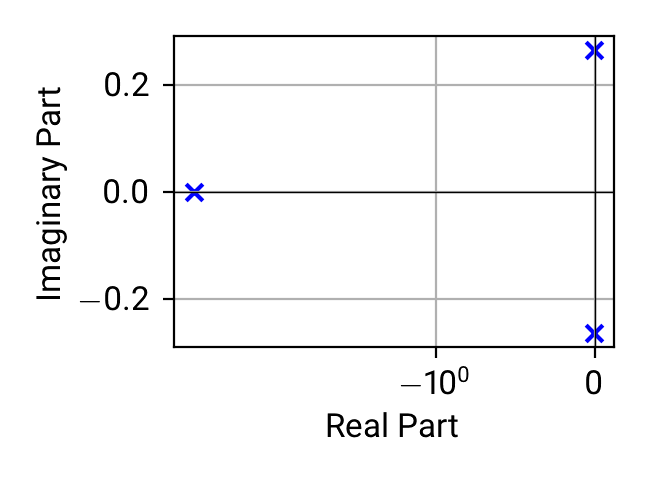

In [5]:
# Eigenvalues decay chain POD collapse
N_nuclides = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e2, 69)
POD.initial_composition[0] = 1
POD.run_simulation(
    np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
rom.spatial_snapshots(POD, 5)
rom.reduce_SVD(POD, 3)
rom.run_simulation_reduced(POD)
eigs, eigvecs = np.linalg.eig(POD.decay_array_red)

# Make dataframes of results
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"

df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)


# Generate plots
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=1.1, show_legend=True)
    + theme_linedraw()
    + scale_color_manual(cbbPalette)
    + theme(figure_size=(3.25, 2.4), legend_key_size=12)
    + theme(legend_key=element_blank(), legend_background=element_blank())
)
print(np.min(np.real(eigs)) / np.max(np.real(eigs)))
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig(
    "../writing/figures/POD-collapse_eigen.png",
    bbox_inches="tight",
    pad_inches=0.03,
    dpi=300,
)

# Display the plot
ggsave(plot_chain, "../writing/figures/POD-collapse_chain", dpi=300)

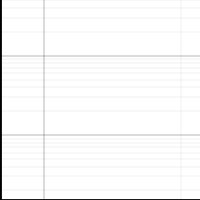

In [13]:
# Plot to show order buildup of stiffness 5 decay chain with reassignment
# V: Ticks zou nog bij 1 kunnen beginnen
result = pd.read_csv("POD/JBF_methode/chainBuildup_stiffness5.csv")
result = result[result["Reduction order"] <= 100]
result["Eigenvalue reassignment"] = result["Eigenvalue reassignment"].astype(
    "category")
plot5 = (
    ggplot(
        result,
        aes(
            x="Reduction order",
            y="Error",
            shape="Eigenvalue reassignment",
            color="Eigenvalue reassignment",
        ),
    )
    + scale_shape_manual(
        values=["o", "d", "x"], labels=["Unchanged", "Shifted", "and Reassigned"]
    )
    + scale_color_manual(cbbPalette,
                         labels=["Unchanged", "Shifted", "and Reassigned"])
    + geom_point()
    + scale_y_log10()
    + theme_linedraw()
    + labs(shape="Eigenvalues", color="Eigenvalues", y="Stiffness $10^{25}$")
    + theme(legend_position="top")
    + theme(legend_key=element_blank(), legend_background=element_blank())
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_blank(),
        axis_ticks_major_x=element_blank(),
    )
)
order5 = pw.load_ggplot(plot5, figsize=(6, 2))

result = pd.read_csv("POD/JBF_methode/chainBuildup_stiffness12.csv")
result = result[result["Reduction order"] <= 100]
result["Eigenvalue reassignment"] = result["Eigenvalue reassignment"].astype(
    "category")
plot12 = (
    ggplot(
        result,
        aes(
            x="Reduction order",
            y="Error",
            shape="Eigenvalue reassignment",
            color="Eigenvalue reassignment",
        ),
    )
    + scale_shape_manual(
        values=["o", "d", "x"], labels=["Unchanged", "Shifted", "and Reassigned"]
    )
    + scale_color_manual(cbbPalette,
                         labels=["Unchanged", "Shifted", "and Reassigned"])
    + geom_point()
    + scale_y_log10()
    + theme_linedraw()
    + labs(
        shape="Eigenvalues",
        y="Stiffness $10^{25}$",
        color="Eigenvalues",
    )
    + theme(legend_position="none")
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_blank(),
        axis_ticks_major_x=element_blank(),
    )
)
order12 = pw.load_ggplot(plot12, figsize=(6, 2))

result = pd.read_csv("POD/JBF_methode/chainBuildup_stiffness25.csv")
result = result[result["Reduction order"] <= 100]
result["Eigenvalue reassignment"] = result["Eigenvalue reassignment"].astype(
    "category")
plot25 = (
    ggplot(
        result,
        aes(
            x="Reduction order",
            y="Error",
            shape="Eigenvalue reassignment",
            color="Eigenvalue reassignment",
        ),
    )
    + scale_shape_manual(
        values=["o", "x"], labels=["Unchanged", "Shifted and Reassigned"]
    )
    + scale_color_manual(
        cbbPalette[::2], labels=["Unchanged", "Shifted and Reassigned"]
    )
    + geom_point()
    + scale_y_log10(limits=(0.9, 100))
    + theme_linedraw()
    + labs(
        shape="Eigenvalues",
        y="Stiffness $10^{25}$",
        color="Eigenvalues",
    )
    + theme(legend_position="none")
)
order25 = pw.load_ggplot(plot25, figsize=(6, 2))
full_plot = pw.stack([order5, order12, order25], margin=0, operator="/")
full_plot.set_supxlabel("Normalised relative error")
full_plot.savefig("../writing/figures/SPOD_buildup.png")

Normalised total error: 9.997e-01
Normalised total error: 4.174e-02


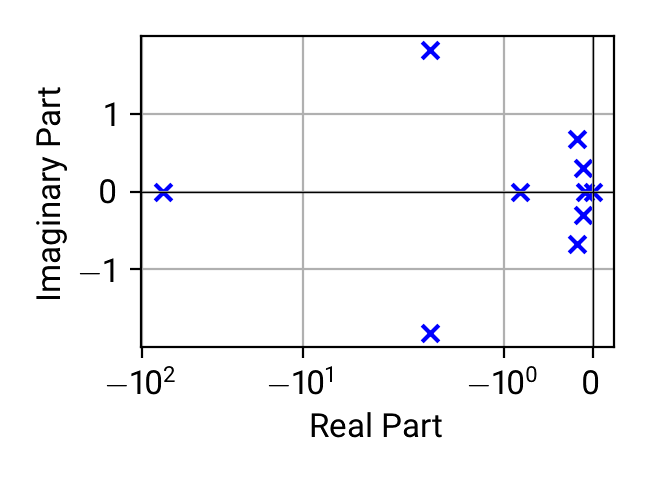

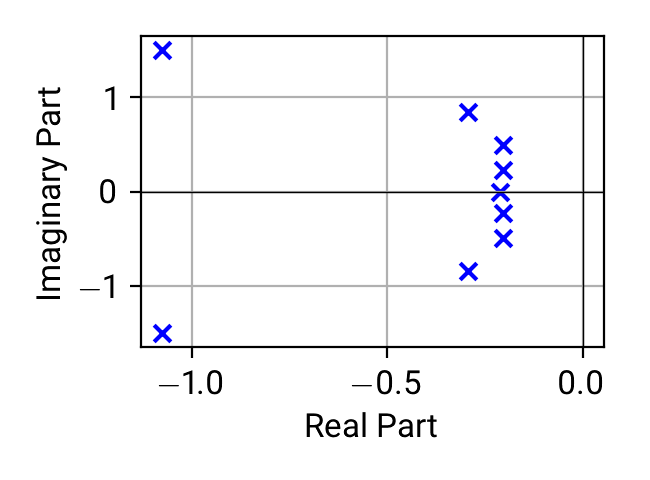

In [30]:
# Comparision collapsing POD vs stable BT in BT chapter
N_nuclides = 200
red_order = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e5, 42)
POD.initial_composition[0] = 1
POD.run_simulation(np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
rom.spatial_snapshots(POD, 500)
rom.reduce_SVD(POD, red_order)
rom.run_simulation_reduced(POD)
rom.print_error(POD)

# POD eigs plot
eigs, _ = np.linalg.eig(POD.decay_array_red)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("../writing/figures/BT-compareCollapse_a.png",,bbox_inches="tight", pad_inches=.03,  dpi=300)

# POD sim plot
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=0.75, show_legend=False)
    + theme_linedraw()
    + scale_color_manual(repeating_palette(200))
    + theme(figure_size=(3.25, 2.4))
)
ggsave(plot_chain, "../writing/figures/BT-compareCollapse_b", dpi=300)

# BT
A = POD.decay_array
B = np.zeros((200, 1))
B[0] = 1
C = np.diag(np.ones(200))
state = ct.ss(A, B, C, 0)
state_red = ct.balred(state, red_order)
POD.decay_array_red = state_red.A
POD.initial_composition_red = state_red.B[:, 0]
POD.rom_basis = state_red.C
rom.run_simulation_reduced(POD)
rom.print_error(POD)

# BT eigs plot
eigs, _ = np.linalg.eig(POD.decay_array_red)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("../writing/figures/BT-compareCollapse_c.png", dpi=300,bbox_inches="tight", pad_inches=.03, )

# BT sim plot
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"
df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=0.75, show_legend=False)
    + theme_linedraw()
    + scale_color_manual(repeating_palette(200))
    + theme(figure_size=(3.25, 2.4))
)
ggsave(
    plot_chain, "../writing/figures/BT-compareCollapse_d", dpi=300, bbox_inches="tight"
)

Normalised total error: 5.876e-01
Normalised total error: 5.113e-02


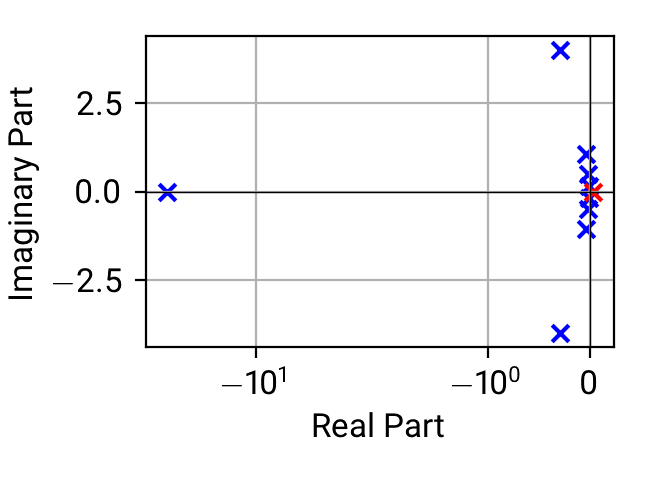

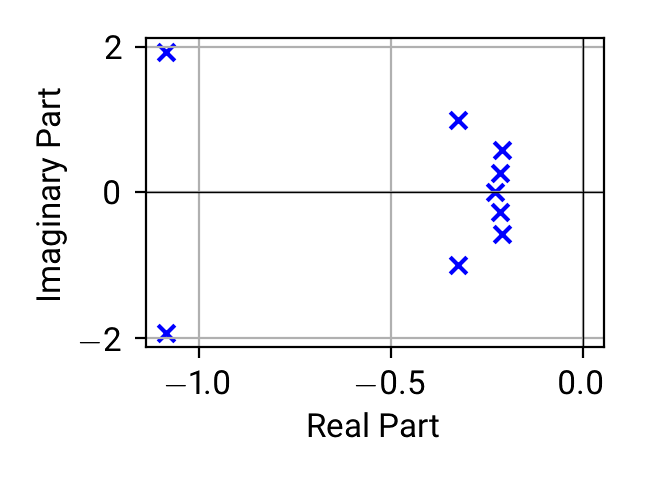

In [2]:
# Comparision exploding POD vs stable BT in BT chapter
N_nuclides = 200
red_order = 10
POD = rom.DecayChain(N_nuclides)
rom.build_decay_chain(POD, 1, 1e5, 69)
POD.initial_composition[0] = 1
POD.run_simulation(np.sum(2 / POD.decay_constants[:-1]), 10000, "Euler_backward")
rom.spatial_snapshots(POD, 500)
rom.reduce_SVD(POD, red_order)
POD.sim_time = 200
rom.run_simulation_reduced(POD)
rom.print_error(POD)

# POD eigs plot
eigs, _ = np.linalg.eig(POD.decay_array_red)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("../writing/figures/BT-compareExplode_a.png", dpi=300)

# POD sim plot
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=0.75, show_legend=False)
    + theme_linedraw()
    + scale_color_manual(repeating_palette(200))
    + theme(figure_size=(3.25, 2.4))
)
ggsave(
    plot_chain, "../writing/figures/BT-compareExplode_b", dpi=300, bbox_inches="tight"
)

# BT
POD.sim_time = np.sum(2 / POD.decay_constants[:-1])
A = POD.decay_array
B = np.zeros((200, 1))
B[0] = 1
C = np.diag(np.ones(200))
state = ct.ss(A, B, C, 0)
state_red = ct.balred(state, red_order)
POD.decay_array_red = state_red.A
POD.initial_composition_red = state_red.B[:, 0]
POD.rom_basis = state_red.C
rom.run_simulation_reduced(POD)
rom.print_error(POD)

# BT eigs plot
eigs, _ = np.linalg.eig(POD.decay_array_red)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig("../writing/figures/BT-compareExplode_c.png", dpi=300, bbox_inches="tight")

# BT sim plot
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")
nuclides[9] = "$N_{10}$"
df = pd.DataFrame(
    np.vstack((POD.solution_red.t, POD.solution_red.y)).T,
    columns=["Time (s)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (s)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)
plot_chain = (
    ggplot(df, aes(x="Time (s)", y="Nuclide amount"))
    + ylab("Nuclide amount")
    + geom_line(aes(color="Nuclide"), size=0.75, show_legend=False)
    + theme_linedraw()
    + scale_color_manual(repeating_palette(200))
    + theme(figure_size=(3.25, 2.4))
)
ggsave(plot_chain, "../writing/figures/BT-compareExplode_d", dpi=300)

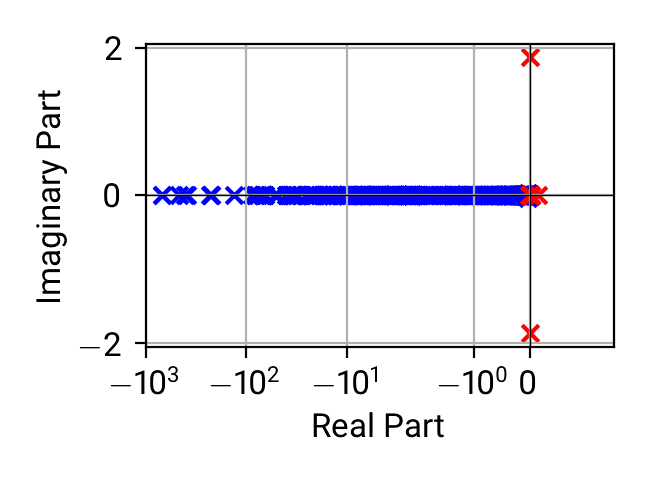

In [5]:
# MSFR simulation with eigenvalues
time = 3e8
N_snapshots = 1000
N_nuclides = 1650
with h5py.File("BPOD/MSFR/baseline_1000snaps_30days.h5", "r") as file:
    baseline = file["baseline"][:]
    init_comp = file["N0"][:]
sim_times = np.linspace(0 + 30 * 24 * 3600, time + 30 * 24 * 3600, N_snapshots + 1)
solution = scipy.optimize.OptimizeResult(t=sim_times, y=baseline)
burnup = rom.read_burnup_file("BPOD/MSFR/MSFR_30days.m")
eigs, _ = np.linalg.eig(burnup["A"])

# Make dataframes of results
nuclides = []
for a in range(N_nuclides):
    nuclides.append("$N_" + str(a + 1) + "$")

df = pd.DataFrame(
    np.vstack((solution.t / (365.25 * 24 * 3600), solution.y)).T,
    columns=["Time (years)"] + nuclides,
)
df = pd.melt(
    df,
    value_vars=nuclides,
    id_vars="Time (years)",
    var_name="Nuclide",
    value_name="Nuclide amount",
)


# Generate plots
plot_chain = (
    ggplot(df, aes(x="Time (years)", y="Nuclide amount"))
    + ylab("Atomic density $(\\mathrm{b}^{-1}\\,\\mathrm{cm}^{-1})$")
    + geom_line(aes(color="Nuclide"), size=0.5, show_legend=False)
    + theme_linedraw()
    + scale_color_manual(repeating_palette(1650))
    + theme(figure_size=(3.25, 2.4))
    + scale_y_log10()
    + scale_y_continuous(trans="log10", limits=(1e-9, 0.02))
)
plt.figure(figsize=(3.25, 2.4))
plt.scatter(
    np.real(eigs[eigs < 0]),
    np.imag(eigs[eigs < 0]),
    color="blue",
    marker="x",
)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.scatter(
    np.real(eigs[eigs > 0]),
    np.imag(eigs[eigs > 0]),
    color="red",
    marker="x",
)
plt.grid(True)
plt.xscale("symlog")
plt.xlim(-1000, 1.5)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig(
    "../writing/figures/BPOD-MSFR_eigen.png",
    bbox_inches="tight",
    pad_inches=0.03,
    dpi=300,
)

# Display the plot
ggsave(
    plot_chain,
    "../writing/figures/BPOD-MSFR_sim",
    dpi=300,
    bbox_inches="tight",
)

In [6]:
# BPOD MSFR performance plots
df = pd.read_csv("BPOD/MSFR/performanceMSFR.csv")
df_long = pd.melt(
    df,
    id_vars=["Orders"],
    value_vars=["Total error", "Max error"],
    var_name="Error Type",
    value_name="Error",
)
df_long["Error Type"] = df_long["Error Type"].replace(
    {"Max error": "Max nuclide error"}
)
y_ticks = [10**i for i in range(-6, 1)]

errorPlot = (
    ggplot(data=df_long)
    + geom_point(
        aes(x="Orders", y="Error", color="Error Type"),
        shape="s",
        position=position_dodge(width=0.5),
    )
    + scale_y_log10(breaks=y_ticks)  # Ensure the y-axis is on a log scale
    + theme_linedraw()
    + theme(figure_size=(3, 2.4))
    + ylab("Normalised relative error")
    + xlab("Reduced modes")
    + scale_color_manual(
        values={"Total error": cbbPalette[0],
                "Max nuclide error": cbbPalette[1]},
        name="Error Type",
    )
    + scale_y_continuous(trans="log10", breaks=y_ticks, limits=(1e-6, 1))
    + scale_x_continuous(
        breaks=range(int(df["Orders"].min()), int(df["Orders"].max()) + 1)
    )  # Set xticks at every number
    + theme(legend_key=element_blank(), legend_background=element_blank())
    + theme(
        legend_position="top", legend_title=element_blank()
    )  # Move the legend to the top
)


speedPlot = (
    ggplot(data=df)
    + geom_point(aes(x="Orders", y="Steptime"))
    + theme_linedraw()
    + theme(figure_size=(3.25, 2.4))
    + xlab("Reduced modes")
    + ylab("Runtime per step (s)")
    + scale_x_continuous(
        breaks=range(int(df["Orders"].min()), int(df["Orders"].max()) + 1)
    )  # Set xticks at every number
    + scale_color_manual(
        values={"Total error": "red", "Max error": "blue"}, name="Error Type"
    )
)
ggsave(
    errorPlot,
    "../writing/figures/BPOD-MSFR_error",
    width=3,
    height=2.4,
    dpi=300,
    bbox_inches="tight",
)
ggsave(speedPlot, "../writing/figures/BPOD-MSFR_speed",
       dpi=300, bbox_inches="tight")

In [4]:
# BPOD MSFR FP plot
time = 3e8
N_snapshots = 1000
N_nuclides = 1650
with h5py.File("BPOD/MSFR/baseline_1000snaps_30days.h5", "r") as file:
    baseline = file["baseline"][:]
    init_comp = file["N0"][:]
burnup = rom.read_burnup_file("BPOD/MSFR/MSFR_30days.m")
sim_times = np.linspace(0 + 30 * 24 * 3600, time +
                        30 * 24 * 3600, N_snapshots + 1)
solution = scipy.optimize.OptimizeResult(t=sim_times, y=baseline)

# Simulation BPOD
Bpod = rom.DecayChain(N_nuclides)
Bpod.sim_time = time
Bpod.sim_steps = N_snapshots
Bpod.solution = solution
Bpod.decay_array = burnup["A"]
Bpod.solver = "Radau"
Bpod.initial_composition = init_comp
with h5py.File("BPOD/MSFR/OUT_MSFR/OUT_1_modes_500_snapshots.h5", "r") as file:
    to_FOM = file["to_FOM"][:].T
    to_ROM = file["to_ROM"][:].T
    N_snaps = file["N_snapshots"][()]
    N_rom = file["N_rom"][()]
rom.reduce_abstract(Bpod, N_rom)
Bpod.decay_array_red = to_ROM @ Bpod.decay_array @ to_FOM
Bpod.initial_composition_red = to_ROM @ Bpod.initial_composition
Bpod.rom_basis = to_FOM
rom.run_simulation_reduced(Bpod, log_scale=True)

# Prepare the data
index = np.arange(100) + 550
data1 = Bpod.solution.y[550:650, 1000]
data2 = Bpod.solution_red.y[550:650, 1000]

# Create a DataFrame
df = pd.DataFrame(
    {
        "Index": np.tile(index, 2),
        "Nuclide amount": np.concatenate((data1, data2)),
        "Type": ["solution"] * 100 + ["solution_red"] * 100,
    }
)

# Plotting with plotnine
plot1 = (
    ggplot(df, aes(x="Index", y="Nuclide amount", fill="Type"))
    + geom_bar(stat="identity", position="identity")
    + theme_linedraw()
    + xlab("Index")
    + ylab("Atomic density $(\\mathrm{b}^{-1}\\,\\mathrm{cm}^{-1})$")
    + xlab("ZAI number")
    + theme(figure_size=(3, 2.4), legend_position="none")
    + scale_fill_manual(
        name=" ",
        values={"solution": cbbPalette[1], "solution_red": cbbPalette[0]},
        labels=["FOM", "ROM"],
    )
)

# Simulation
Bpod = rom.DecayChain(N_nuclides)
Bpod.sim_time = time
Bpod.sim_steps = N_snapshots
Bpod.solution = solution
Bpod.decay_array = burnup["A"]
Bpod.solver = "Radau"
Bpod.initial_composition = init_comp
with h5py.File("BPOD/MSFR/OUT_MSFR/OUT_2_modes_500_snapshots.h5", "r") as file:
    to_FOM = file["to_FOM"][:].T
    to_ROM = file["to_ROM"][:].T
    N_snaps = file["N_snapshots"][()]
    N_rom = file["N_rom"][()]
rom.reduce_abstract(Bpod, N_rom)
Bpod.decay_array_red = to_ROM @ Bpod.decay_array @ to_FOM
Bpod.initial_composition_red = to_ROM @ Bpod.initial_composition
Bpod.rom_basis = to_FOM
rom.run_simulation_reduced(Bpod, log_scale=True)

# Prepare the data
index = np.arange(100) + 550
data12 = Bpod.solution.y[550:650, 1000]
data22 = Bpod.solution_red.y[550:650, 1000]

# Create a DataFrame
df2 = pd.DataFrame(
    {
        "Index": np.tile(index, 2),
        "Nuclide amount": np.concatenate((data12, data22)),
        "Type": ["solution"] * 100 + ["solution_red"] * 100,
    }
)

# Plotting with plotnine
plot2 = (
    ggplot(df2, aes(x="Index", y="Nuclide amount", fill="Type"))
    + geom_bar(stat="identity", position="identity")
    + theme_linedraw()
    + xlab("Index")
    + theme(figure_size=(3.25, 2.4))
    + ylab("Atomic density $(\\mathrm{b}^{-1}\\,\\mathrm{cm}^{-1})$")
    + xlab("ZAI number")
    + scale_fill_manual(
        name=" ",
        values={"solution": cbbPalette[1], "solution_red": cbbPalette[0]},
        labels=["FOM", "ROM"],
    )
)

# Save plots
ggsave(
    plot1, "../writing/figures/BPOD-MSFR_BPOD_FP_1mode", dpi=300, bbox_inches="tight"
)
ggsave(
    plot2, "../writing/figures/BPOD-MSFR_BPOD_FP_2mode", dpi=300, bbox_inches="tight"
)

# Print normed error compared to SERPENT afer 5000 days
time = 4970 * 24 * 3600
N_snapshots = 1000
N_nuclides = 1650
with h5py.File("BPOD/MSFR/baseline_1000snaps_30days.h5", "r") as file:
    baseline = file["baseline"][:]
    init_comp = file["N0"][:]
burnup = rom.read_burnup_file("BPOD/MSFR/MSFR_30days.m")
sim_times = np.linspace(0 + 30 * 24 * 3600, time +
                        30 * 24 * 3600, N_snapshots + 1)
solution = scipy.optimize.OptimizeResult(t=sim_times, y=baseline)

# Simulation BPOD
Bpod = rom.DecayChain(N_nuclides)
Bpod.sim_time = time
Bpod.sim_steps = N_snapshots
Bpod.solution = solution
Bpod.decay_array = burnup["A"]
Bpod.solver = "Radau"
Bpod.initial_composition = init_comp
with h5py.File("BPOD/MSFR/OUT_MSFR/OUT_4_modes_500_snapshots.h5", "r") as file:
    to_FOM = file["to_FOM"][:].T
    to_ROM = file["to_ROM"][:].T
    N_snaps = file["N_snapshots"][()]
    N_rom = file["N_rom"][()]
rom.reduce_abstract(Bpod, N_rom)
Bpod.decay_array_red = to_ROM @ Bpod.decay_array @ to_FOM
Bpod.initial_composition_red = to_ROM @ Bpod.initial_composition
Bpod.rom_basis = to_FOM
rom.run_simulation_reduced(Bpod, log_scale=True)
serpentData = rom.read_burnup_file(
    "serpent/data_longBurn/depmtx_fuel23.m")["N1"][:, 0]